In [ ]:
!pip3 install kymatio
!pip3 install scikit-cuda
!pip uninstall --y torchvision
!pip install torch==1.7.0 torchvision==0.8.0
!pip install -U git+https://github.com/albumentations-team/albumentations_experimental

     |████████████████████████████████| 102kB 4.4MB/s 
     |████████████████████████████████| 122kB 5.7MB/s 
     |████████████████████████████████| 1.7MB 25.5MB/s 
  Installing build dependencies ... done


In [1]:
import numpy as np 
import os,csv
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
import albumentations as A
import random
from torchvision import transforms
import torch.optim
from PIL import Image
#from kymatio.torch import Scattering2D
import pickle
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
import csv
from google.colab import drive
drive.mount('/content/drive', force_remount = True )
# 4/1AY0e-g4UbHq_CkCkQLG7ug0yUnXepWmT7pS_gsiVPgrnh2-PU7RKqA7JzTk

Mounted at /content/drive


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
NUM_EPOCHS = 25
BATCH_SIZE = 16
LEARNING_RATE = 1e-3

In [5]:
def getImageName(filename):
    imageName = filename[:-4] + '_Annotation.png'
    return imageName

In [6]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self, target, pred):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [7]:
def iou_binary(out, labels, EMPTY=1., ignore=None, per_image=True, threshold=0.5):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    out = torch.sigmoid(out)
    preds = (out.data > threshold).long()
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = np.mean(np.array(ious))    # mean accross images if per_image
    return 100 * iou

In [8]:
from PIL import ImageFilter
preprocessing = 0
class HeadDataset(Dataset):

    def __init__(self, image_path, mask_path, files, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.files = files
        self.transform = transform
        self.aug = A.Compose([
                A.CLAHE(clip_limit=5.0, tile_grid_size=(8, 8), always_apply=False, p=0.5) ,
                A.Blur(blur_limit=3)
            ])


    def __len__(self) :
        return len(self.files)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_path,self.files[idx])
        mask_name = os.path.join(self.mask_path,getImageName(self.files[idx]))
        
        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')

        #print(type(image))
        image = self.aug(image=np.array(image))['image']
        image = Image.fromarray(image)
        image = image.convert('L')

        #print("yes")

        if self.transform :
            image = self.transform(image)
            mask = self.transform(mask)
        #print(type(image))
        #print("yes")
        #image = self.aug(image=np.array(image))['image']
        
        image = image.to(device=device)
        mask = mask.to(device=device)
        
        sample = {'image': image, 'mask': mask}
        return sample


In [9]:
base_folder = '/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
image_folder = base_folder
mask_folder = base_folder

In [10]:
transform = transforms.Compose([
    transforms.Resize((544, 800)),
    transforms.ToTensor()
    #transforms.Normalize((0.485), (0.229))
])

In [11]:
with open('/content/drive/MyDrive/cv/manaswini/HC-18/train.pkl', 'rb') as fid:
    train = pickle.load(fid)
with open('/content/drive/MyDrive/cv/manaswini/HC-18/val.pkl', 'rb') as fid:
    val = pickle.load(fid)
    
Head_Train_Dataset = HeadDataset(image_folder,mask_folder,train,transform)
trainLoader = DataLoader(Head_Train_Dataset, batch_size=BATCH_SIZE,shuffle=True)

Val_Dataset = HeadDataset(image_folder,mask_folder,val,transform)
valLoader = DataLoader(Val_Dataset, batch_size=BATCH_SIZE,shuffle=True)

In [12]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [13]:
import segmentation_models_pytorch as smp
model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=1, classes=1).to(device)

criterion = diceloss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE*0.1)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

In [14]:
iou_score_train = []
dice_loss_train = []
iou_score_val= []
dice_loss_val = []
best_iou_score = -np.inf

In [15]:
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    ##training
    model.train()
    for i, data in tqdm( enumerate(trainLoader,0), total=int(len(Head_Train_Dataset)/trainLoader.batch_size)):
        iou = []
        loss_arr = []
        # get the inputs; data is a list of [inputs, labels]
        images = data['image']
        masks = data['mask']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, masks)
        #print("Training: Mini - Batch ",i,"Loss", loss.item())
        with torch.no_grad():
            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))
            loss_arr.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    iou_score_train.append(np.mean(iou))
    dice_loss_train.append(np.mean(loss_arr))

    ##evaluation
    model.eval()
    with torch.no_grad():
        iou = []
        loss_arr = []
        for k, data in tqdm(enumerate(valLoader,0), total=int(len(Val_Dataset)/valLoader.batch_size)):
            # get the inputs; data is a list of [inputs, labels]
            images = data['image'].to(device)
            masks = data['mask'].to(device)
            # scatters = data['scatter']

            outputs = model(images)
            loss = criterion(outputs, masks)
            #print("Validation: Mini - Batch ",k,"Loss", loss.item())

            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))
            loss_arr.append(loss.item())
   
    iou_score_val.append(np.mean(iou))
    dice_loss_val.append(np.mean(loss_arr))

    with open('/content/drive/MyDrive/cv/manaswini/HC-18/smp-clahe-blur-fin/epoch_iousAndArrays.pkl', 'wb') as fid:
        pickle.dump({'iou_score_train':iou_score_train, 'dice_loss_train': dice_loss_train, 'iou_score_val':iou_score_val, 'dice_loss_val':dice_loss_val}, fid)

    if epoch % 1 == 0:
        print("Epoch [{}]: Train - loss:{}, iou:{}; Val - loss:{}, iou:{}".format(epoch, dice_loss_train[-1],iou_score_train[-1], dice_loss_val[-1],iou_score_val[-1]))
        running_loss = 0.0
    

    if iou_score_val[-1]>best_iou_score:
        best_iou_score = iou_score_val[-1]
        torch.save(model.state_dict(), "/content/drive/MyDrive/cv/manaswini/HC-18/smp-clahe-blur-fin/best-model")
        with open('/content/drive/MyDrive/cv/manaswini/HC-18/smp-clahe-blur-fin/best_iou.pkl', 'wb') as fid:
            pickle.dump(best_iou_score, fid)


print('Finished Training')

50it [01:04,  1.29s/it]
13it [00:08,  1.45it/s]


Epoch [0]: Train - loss:0.07422280311584473, iou:79.84837287435391; Val - loss:0.04400743887974666, iou:88.22209902162429


50it [01:04,  1.28s/it]
13it [00:08,  1.46it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [1]: Train - loss:0.04116636514663696, iou:86.44885999994614; Val - loss:0.04390059526150043, iou:87.06678962062543


50it [01:04,  1.28s/it]
13it [00:08,  1.46it/s]


Epoch [2]: Train - loss:0.022834718227386475, iou:92.04326629345428; Val - loss:0.0285912798001216, iou:92.35846372750234


50it [01:04,  1.29s/it]
13it [00:08,  1.47it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [3]: Train - loss:0.03414344787597656, iou:89.69443629465529; Val - loss:0.03306560332958515, iou:91.80747895741686


50it [01:04,  1.28s/it]
13it [00:08,  1.47it/s]


Epoch [4]: Train - loss:0.018227875232696533, iou:94.9949613215695; Val - loss:0.025630561205057, iou:92.98636561604509


50it [01:04,  1.28s/it]
13it [00:08,  1.47it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [5]: Train - loss:0.021253347396850586, iou:91.76161602760918; Val - loss:0.04821147368504451, iou:88.16767682665014


50it [01:04,  1.28s/it]
13it [00:08,  1.46it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [6]: Train - loss:0.026838958263397217, iou:93.7708899604835; Val - loss:0.05539685029249925, iou:85.04850664973584


50it [01:04,  1.29s/it]
13it [00:08,  1.47it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [7]: Train - loss:0.02871614694595337, iou:92.72519463911561; Val - loss:0.06274313651598416, iou:84.36458273239684


50it [01:04,  1.28s/it]
13it [00:08,  1.46it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [8]: Train - loss:0.023484468460083008, iou:90.75855866773284; Val - loss:0.03396916389465332, iou:90.76283422963516


50it [01:04,  1.28s/it]
13it [00:08,  1.45it/s]


Epoch [9]: Train - loss:0.017988920211791992, iou:94.77974271137832; Val - loss:0.024589552329136774, iou:93.15945874488537


50it [01:04,  1.28s/it]
13it [00:08,  1.45it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [10]: Train - loss:0.038241446018218994, iou:87.93346373797765; Val - loss:0.024951068254617546, iou:93.14369017058578


50it [01:04,  1.28s/it]
13it [00:08,  1.46it/s]


Epoch [11]: Train - loss:0.017194509506225586, iou:95.32591965245959; Val - loss:0.025123183543865498, iou:93.48444080622137


50it [01:04,  1.28s/it]
13it [00:08,  1.46it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [12]: Train - loss:0.01711130142211914, iou:95.27222941794555; Val - loss:0.029146153193253737, iou:92.83390415018438


50it [01:03,  1.28s/it]
13it [00:08,  1.47it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [13]: Train - loss:0.025449037551879883, iou:93.32792017640405; Val - loss:0.026121226640848014, iou:92.15080060544445


50it [01:04,  1.28s/it]
13it [00:08,  1.47it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [14]: Train - loss:0.041413724422454834, iou:89.95226136094429; Val - loss:0.03945112686890822, iou:90.61150604215234


50it [01:03,  1.28s/it]
13it [00:08,  1.47it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [15]: Train - loss:0.0698474645614624, iou:88.28040338834104; Val - loss:0.02690101586855375, iou:92.54744295698012


50it [01:04,  1.28s/it]
13it [00:08,  1.46it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [16]: Train - loss:0.02425438165664673, iou:91.47817981881249; Val - loss:0.026159722071427565, iou:93.0546726205085


50it [01:04,  1.28s/it]
13it [00:08,  1.47it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [17]: Train - loss:0.029933512210845947, iou:90.15965690810283; Val - loss:0.023902764687171348, iou:93.32716041482198


50it [01:04,  1.28s/it]
13it [00:08,  1.45it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [18]: Train - loss:0.030966579914093018, iou:89.77016950499352; Val - loss:0.03081028736554659, iou:90.87104670370165


50it [01:04,  1.28s/it]
13it [00:09,  1.44it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [19]: Train - loss:0.03151845932006836, iou:90.73611385875675; Val - loss:0.05529738848025982, iou:86.40636417874273


50it [01:03,  1.28s/it]
13it [00:08,  1.47it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [20]: Train - loss:0.019881606101989746, iou:94.66233886861973; Val - loss:0.02468337920995859, iou:93.08214528111608


50it [01:03,  1.28s/it]
13it [00:08,  1.45it/s]


Epoch [21]: Train - loss:0.01751840114593506, iou:93.13427357349143; Val - loss:0.023288717636695273, iou:93.84827007310835


50it [01:03,  1.28s/it]
13it [00:08,  1.47it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [22]: Train - loss:0.014973342418670654, iou:95.28328810355075; Val - loss:0.02542057862648597, iou:93.17788716506321


50it [01:04,  1.28s/it]
13it [00:08,  1.47it/s]
  0%|          | 0/49 [00:00<?, ?it/s]

Epoch [23]: Train - loss:0.018665313720703125, iou:92.79016031526712; Val - loss:0.022602626910576455, iou:92.98812367927856


50it [01:04,  1.28s/it]
13it [00:08,  1.46it/s]

Epoch [24]: Train - loss:0.01867121458053589, iou:94.74888518852309; Val - loss:0.058423560399275556, iou:88.50258342796563
Finished Training


In [16]:
print(best_iou_score)

93.84827007310835


In [17]:

def plot(scores, name) :
      plt.figure(figsize=(15,5))
      plt.plot(range(len(scores)), scores, label=f'train {name}',marker=".")
      #plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
      plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
      plt.legend(); 
      plt.show()

In [18]:
with open('/content/drive/MyDrive/cv/manaswini/HC-18/smp-clahe-blur-fin/epoch_iousAndArrays.pkl', 'rb') as fid:
    data = pickle.load(fid)
    iou_score_train_cla = data['iou_score_train']
    dice_loss_train_cla = data['dice_loss_train']
    iou_score_val_cla = data['iou_score_val']
    dice_loss_val_cla = data['dice_loss_val']
    print(dice_loss_val_cla[np.argmax(iou_score_val_cla)])
    print(np.max(iou_score_val_cla))

0.023288717636695273
93.84827007310835


In [19]:
with open('/content/drive/MyDrive/cv/manaswini/HC-18/smp-preproc/epoch_iousAndArrays.pkl', 'rb') as fid:
    data = pickle.load(fid)
    iou_score_train_pre = data['iou_score_train']
    dice_loss_train_pre = data['dice_loss_train']
    iou_score_val_pre = data['iou_score_val']
    dice_loss_val_pre = data['dice_loss_val']
    print(dice_loss_val[np.argmax(iou_score_val)])
    print(np.max(iou_score_val))

0.023288717636695273
93.84827007310835


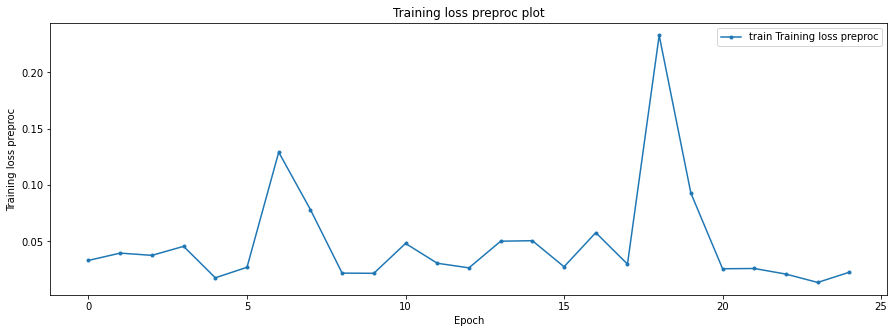

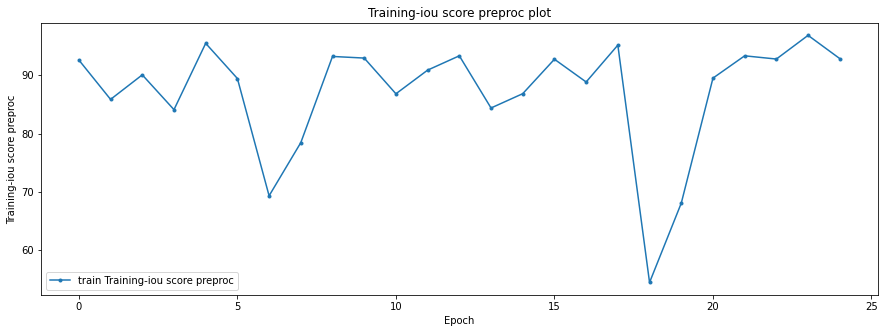

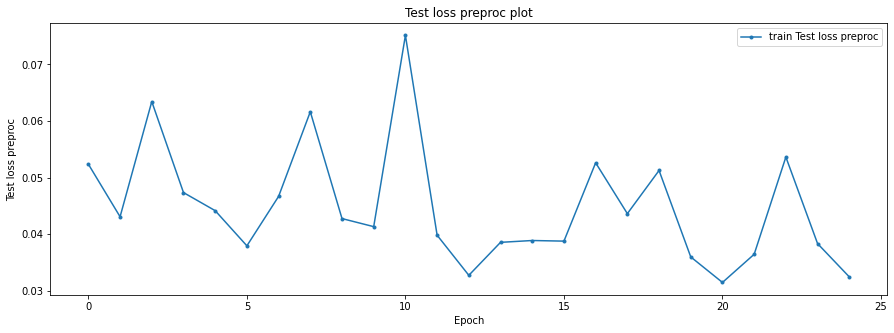

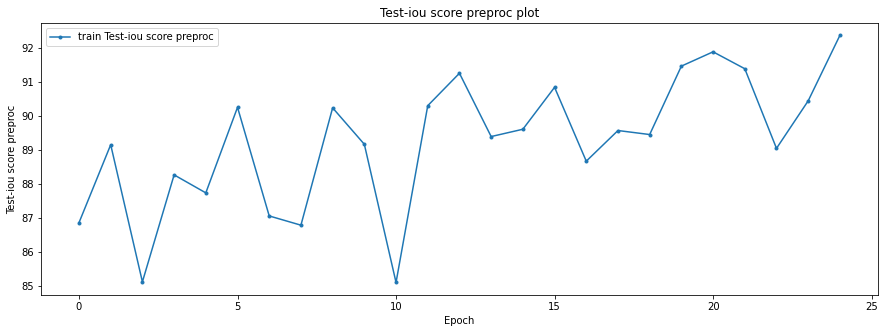

In [20]:
#25epochs-test_train split
epoch_train_losses = dice_loss_train_pre
epoch_train_iou = iou_score_train_pre
epoch_val_losses = dice_loss_val_pre
epoch_val_iou = iou_score_val_pre
plot(epoch_train_losses, "Training loss preproc")
plot(epoch_train_iou, "Training-iou score preproc")
plot(epoch_val_losses, "Test loss preproc")
plot(epoch_val_iou, "Test-iou score preproc")

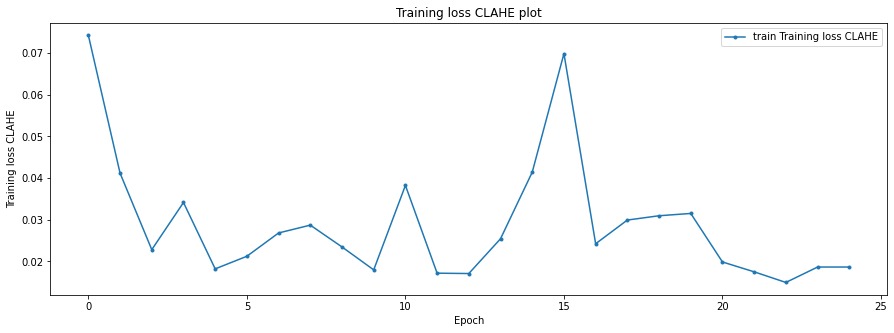

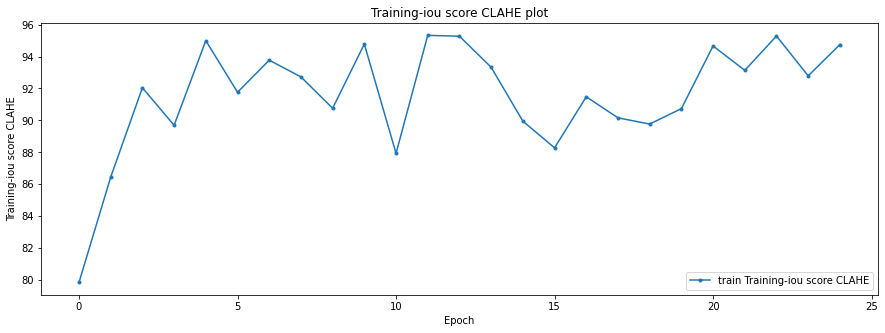

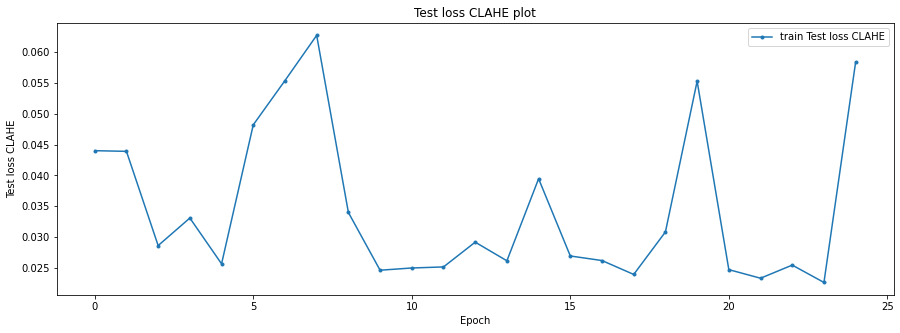

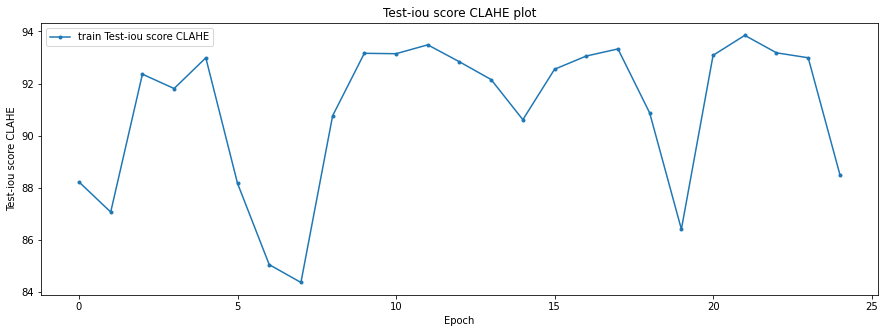

In [21]:
epoch_train_losses = dice_loss_train_cla
epoch_train_iou = iou_score_train_cla
epoch_val_losses = dice_loss_val_cla
epoch_val_iou = iou_score_val_cla
plot(epoch_train_losses, "Training loss CLAHE")
plot(epoch_train_iou, "Training-iou score CLAHE")
plot(epoch_val_losses, "Test loss CLAHE")
plot(epoch_val_iou, "Test-iou score CLAHE")

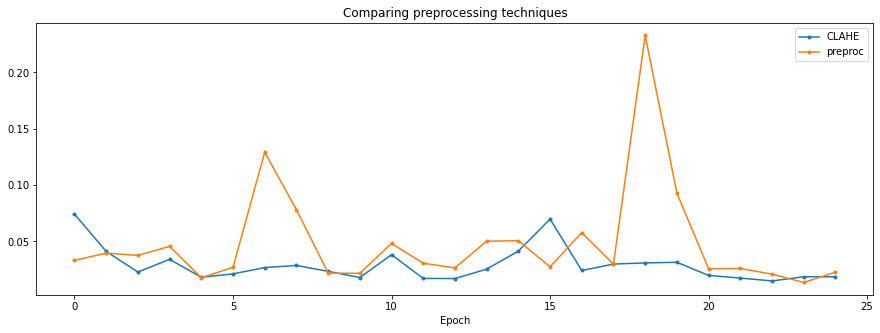

In [22]:
def plot_2(score1,score2,xlabel,title_name,leg1,leg2):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(score1)), score1,marker=".")
    plt.plot(range(len(score2)), score2,marker = ".")
    #plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(title_name);
    plt.xlabel(xlabel)
    plt.legend([leg1,leg2]); 
    plt.show()
plot_2(dice_loss_train_cla,dice_loss_train_pre,"Epoch","Comparing preprocessing techniques","CLAHE","preproc")    

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cv/manaswini/HC-18/smp-clahe/best-model'))

In [ ]:
blur=((3,3),1)
erode_=(5,5)
dilate_=(3, 3)
#plt.imshow( mask , cv2.dilate(cv2.erode(cv2.GaussianBlur(mask/255, blur[0], blur[1]), np.ones(erode_)), np.ones(dilate_))*255)

In [ ]:
# evaluate model:
model.eval()
iou = []
with torch.no_grad():
    for k, data in enumerate(valLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image'].to(device)
        masks = data['mask'].to(device)

        outputs = model(images)
        iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))
        for i in range(images.shape[0]):
            f, ax = plt.subplots(1,4,figsize=(10,10))
            
            ax[0].axis('off')
            ax[0].set_title('Original image')
            ax[1].axis('off')
            ax[1].set_title('Target mask')
            ax[2].axis('off')
            ax[2].set_title('Predicted mask')
            ax[3].axis('off')
            ax[3].set_title('Eroded and Dilated')
            image = transforms.ToPILImage()(images[i])
            ax[0].imshow(image,cmap='gray')
            mask = transforms.ToPILImage()(masks[i])

            ax[1].imshow(mask,cmap='gray')
            output = torch.sigmoid(outputs[i])
            output = (output.data > 0.59).long()
            # print(output)
            # output = transforms.ToPILImage()(output)
            output = torch.squeeze(output, 0)
            #kernel_e = np.ones((6, 6), np.uint8)
            #kernel_d = np.ones((6, 6), np.uint8)
            mask2 = cv2.dilate(cv2.erode(cv2.GaussianBlur(np.array(output.cpu())/255, blur[0], blur[1]), np.ones(erode_)), np.ones(dilate_))*255
            for i in range(15) :
                mask2 = cv2.dilate(cv2.erode(mask2, np.ones(erode_)), np.ones(dilate_))
            ax[2].imshow(output.cpu(),cmap='gray')
            ax[3].imshow(mask2,cmap='gray')
            plt.show()
        break

print('Finished Evaluation')
# print('iou:',np.mean(iou))

In [ ]:
trans1 = transforms.ToTensor()

In [ ]:
# evaluate model:
model.eval()
iou = []
with torch.no_grad():
    for k, data in enumerate(trainLoader, 0):
        images = data['image'].to(device)
        masks = data['mask'].to(device)
        outputs = model(images)
        #print(masks.shape[0])        
        iou.append(iou_binary(outputs, masks, per_image=True, threshold=0.59))

print('Finished Evaluation')
print('iou:',np.mean(iou))